$$
\textbf{Music Generation Project: Finishing the Unfinished Symphony}
$$

$$
\textbf{Model 2: GAN}
$$

$$
\text{Realized by: Jebali Wafa and Belanez Hamdi}
$$

####**Introduction**
This project focuses on the generation of music using deep learning models, specifically a Generative Adversarial Network (GAN). The goal is to create a symphony that completes the unfinished music pieces by generating new musical notes, durations, and offsets.

####**Model Description**
The model uses a GAN architecture to generate music, consisting of two neural networks: the **Generator** and the **Discriminator**. The Generator creates music samples, while the Discriminator evaluates them. Over time, the Generator improves at creating realistic music as the Discriminator improves at distinguishing between real and fake music.

####**Conclusion**
This project successfully demonstrates the potential of GANs in the field of music generation, achieving the goal of completing the unfinished symphony with realistic musical sequences.


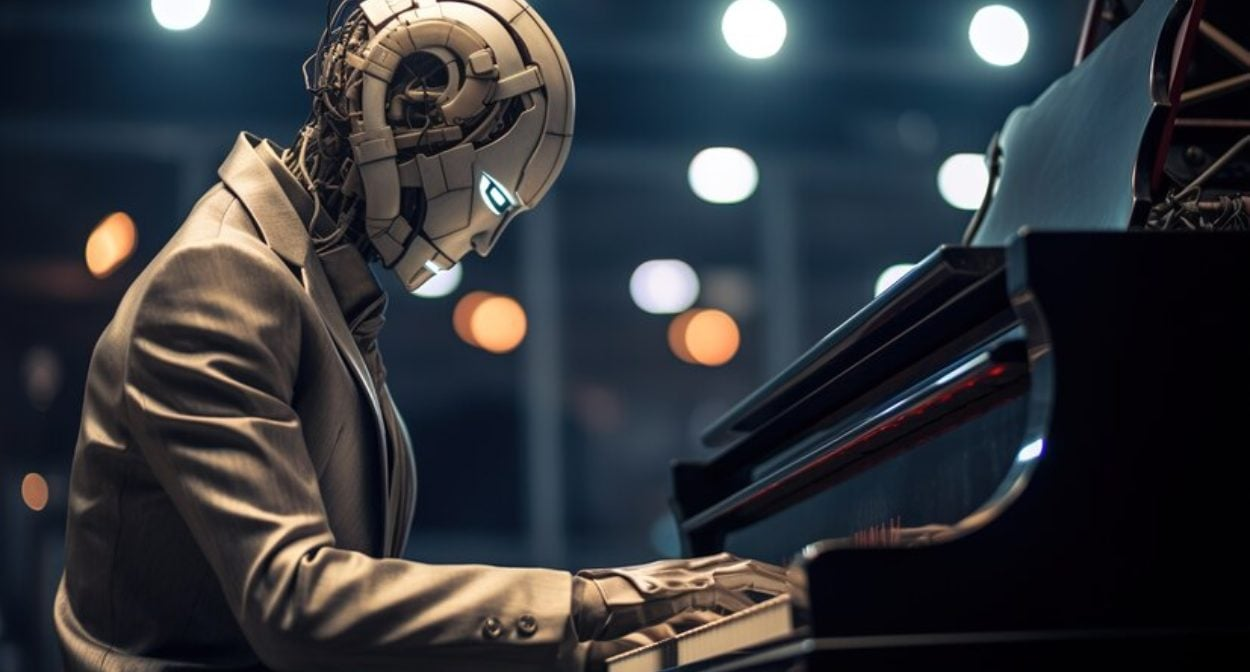

##1. Mount the Drive and load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install mido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.1 MB/s eta 0:00:00


In [3]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 38.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=79cd61982bcdbe39b5246c976e47604529d9e99e5742dcc32aa314b452a4b863
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


##2. Import Libraries

In [2]:
import numpy as np
import pretty_midi
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import glob
from pathlib import Path


##3. Set Constants
Define hyperparameters and file paths for MIDI data input, output, and model configurations.
* **SEQ_LENGTH**: Length of MIDI input sequences to capture temporal patterns.
* **NUM_NOTES**: Total range of MIDI notes, typically 0–127.
* **LATENT_DIM**: Dimensionality of the random noise vector input to the generator.
* **LEARNING_RATE**, BATCH_SIZE, EPOCHS: Control training dynamics.
* **Directories**: Specify locations for input, seed MIDI files, and generated outputs.


In [3]:
SEQ_LENGTH = 100  # Length of the MIDI sequence input
NUM_NOTES = 128   # Number of MIDI notes
LATENT_DIM = 100  # Size of the latent space
LEARNING_RATE = 0.0002
BATCH_SIZE = 64
EPOCHS = 80
MIDI_DIRECTORY = "/content/drive/MyDrive/Music_Gen_Data/input/*.mid"
SEED_MIDI = "/content/drive/MyDrive/Music_Gen_Data/seed/mikansei1.mid"
OUTPUT_DIRECTORY = "/content/sample_data"


##4. Load MIDI Files

Loaded MIDI files are converted into **piano roll** format, representing note activation over time.
Temporal slicing ensures consistent sequence lengths (SEQ_LENGTH), essential for training.
Files with insufficient length are skipped, maintaining quality data.

In [4]:
def load_midi_files(directory):
    data = []
    for filepath in glob.glob(directory):
        try:
            midi_data = pretty_midi.PrettyMIDI(filepath)
            piano_roll = midi_data.get_piano_roll(fs=10)[:NUM_NOTES].T  # Limit to NUM_NOTES
            if piano_roll.shape[0] > SEQ_LENGTH:
                for i in range(0, piano_roll.shape[0] - SEQ_LENGTH, SEQ_LENGTH):
                    data.append(piano_roll[i:i + SEQ_LENGTH])
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
    return np.array(data)
data = load_midi_files(MIDI_DIRECTORY)

##5. Preprocess Data
* **Normalization**: Scales data to [0, 1], improving model stability during * training.
* **Channel Dimension**: Adds an extra dimension for compatibility with convolutional layers.


In [5]:
def preprocess_data(data):
    data = data / np.max(data)  # Normalize data
    data = np.expand_dims(data, -1)  # Add channel dimension for Conv layers
    return data
data = preprocess_data(data)

##6. Build the Generator
* **Generator Role**: Converts random noise (LATENT_DIM) into structured MIDI-like sequences.
* **Dense** Layers: Gradually increase dimensions to match the output size.
* **Activation Functions**:
   * **LeakyReLU**: Prevents vanishing gradients in deep layers.
   * **Sigmoid**: Ensures output in the range [0, 1] for binary activation.
* **Batch Normalization**: Stabilizes training by normalizing intermediate outputs.

In [6]:
def build_generator():
    model = models.Sequential([
        layers.Dense(256, input_dim=LATENT_DIM),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),

        layers.Dense(512),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),

        layers.Dense(1024),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),

        layers.Dense(SEQ_LENGTH * NUM_NOTES, activation="sigmoid"),
        layers.Reshape((SEQ_LENGTH, NUM_NOTES, 1))
    ])
    print("Generator Summary:")
    model.summary()
    return model
generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generator Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12800)               │      13,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 100, 128, 1)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,809,920 (52.68 MB)

 Trainable params: 13,806,336 (52.67 MB)

 Non-trainable params: 3,584 (14.00 KB)

##7. Build the Discriminator
* **Discriminator Role**: Classifies input sequences as real or generated.
* **Convolutional Layers**: Capture spatial and temporal relationships in piano rolls.
* **Dropout Layers:** Prevent overfitting by randomly disabling neurons.
* **Flatten and Dense**: Convert 2D features into a binary classification output.

In [7]:
def build_discriminator():
    model = models.Sequential([
        layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), input_shape=(SEQ_LENGTH, NUM_NOTES, 1)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    print("Discriminator Summary:")
    model.summary()
    return model
discriminator = build_discriminator()

Discriminator Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 49, 63, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 49, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 49, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 31, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 24, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 95232)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │          95,233 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,729 (663.00 KB)

 Trainable params: 169,729 (663.00 KB)

 Non-trainable params: 0 (0.00 B)

##8. Compile the GAN
The **generator** and **discriminator** are combined into a **single GAN model**.
* **Two-Step Loss Optimization**: The discriminator's parameters are frozen while training the generator to prevent interference.
* **Binary Crossentropy Loss**: Used for classification tasks in both models.

In [8]:
def compile_gan(generator, discriminator):
    discriminator.compile(loss="binary_crossentropy", optimizer=Adam(LEARNING_RATE, 0.5), metrics=["accuracy"])
    discriminator.trainable = False

    gan_input = layers.Input(shape=(LATENT_DIM,))
    generated_seq = generator(gan_input)
    gan_output = discriminator(generated_seq)

    gan = models.Model(gan_input, gan_output)
    gan.compile(loss="binary_crossentropy", optimizer=Adam(LEARNING_RATE, 0.5))
    return gan
gan = compile_gan(generator, discriminator)

In [9]:
gan.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 100, 128, 1)         │      13,809,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         169,729 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,979,649 (53.33 MB)

 Trainable params: 13,806,336 (52.67 MB)

 Non-trainable params: 173,313 (677.00 KB)

##9. Train the GAN
The training process involves iteratively improving the generator and discriminator. The discriminator is first trained on batches of real and fake sequences to classify them as real or fake, minimizing its loss for both cases. The generator is then trained to produce realistic sequences that can deceive the discriminator by generating sequences from random noise. Loss values for both the generator and discriminator are tracked over the epochs, providing insight into their progress. At the end of the process, the generator becomes capable of producing high-quality sequences resembling the real data, as indicated by decreasing generator loss and balanced discriminator loss.

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/80 | Discriminator Loss: 0.6922 | Generator Loss: 0.6899


Epoch 2/80 | Discriminator Loss: 0.6904 | Generator Loss: 0.6892
Epoch 3/80 | Discriminator Loss: 0.6892 | Generator Loss: 0.6883
Epoch 4/80 | Discriminator Loss: 0.6887 | Generator Loss: 0.6882
Epoch 5/80 | Discriminator Loss: 0.6885 | Generator Loss: 0.6882
Epoch 6/80 | Discriminator Loss: 0.6884 | Generator Loss: 0.6881
Epoch 7/80 | Discriminator Loss: 0.6885 | Generator Loss: 0.6885
Epoch 8/80 | Discriminator Loss: 0.6889 | Generator Loss: 0.6889
Epoch 9/80 | Discriminator Loss: 0.6891 | Generator Loss: 0.6890
Epoch 10/80 | Discriminator Loss: 0.6892 | Generator Loss: 0.6891
Epoch 11/80 | Discriminator Loss: 0.6893 | Generator Loss: 0.6893
Epoch 12/80 | Discriminator Loss: 0.6894 | Generator Loss: 0.6894
Epoch 13/80 | Discriminator Loss: 0.6895 | Generator Loss: 0.6895
Epoch 14/80 | Discriminator Loss: 0.6896 | Generator Loss: 0.6896
Epoch 15/80 | Discriminator Loss: 0.6896 | Generator Loss: 0.6894
Epoch 16/80 | Discriminator Loss: 0.6895 | Generator Loss: 0.6894
Epoch 17/80 | Disc

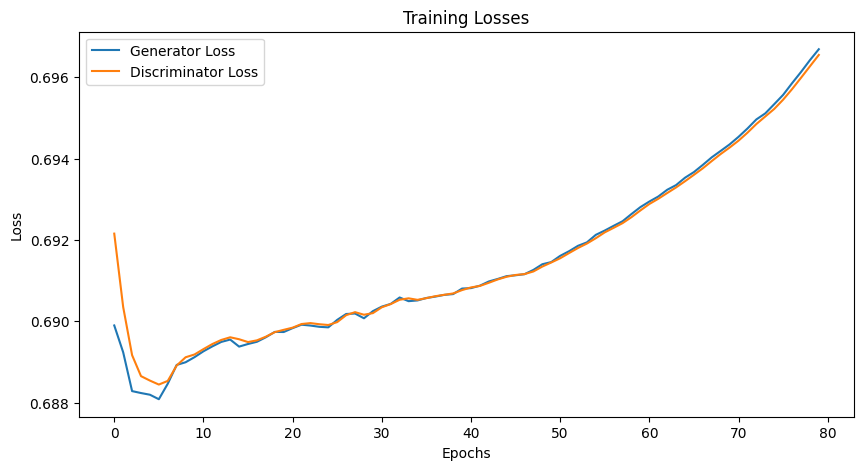

In [10]:
def train_gan(generator, discriminator, gan, data):
    real = np.ones((BATCH_SIZE, 1))
    fake = np.zeros((BATCH_SIZE, 1))

    g_losses = []
    d_losses = []

    for epoch in range(EPOCHS):
        idx = np.random.randint(0, data.shape[0], BATCH_SIZE)
        real_seqs = data[idx]

        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        generated_seqs = generator.predict(noise, verbose=0)

        # Train the discriminator on real and fake data
        d_loss_real = discriminator.train_on_batch(real_seqs, real)
        d_loss_fake = discriminator.train_on_batch(generated_seqs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator via the combined model
        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        g_loss = gan.train_on_batch(noise, real)

        # Ensure scalar values for losses
        d_loss_scalar = float(d_loss[0]) if isinstance(d_loss, (list, np.ndarray)) else float(d_loss)
        g_loss_scalar = float(g_loss[0]) if isinstance(g_loss, (list, np.ndarray)) else float(g_loss)

        g_losses.append(g_loss_scalar)
        d_losses.append(d_loss_scalar)

        # Print training progress
        print(f"Epoch {epoch + 1}/{EPOCHS} | Discriminator Loss: {d_loss_scalar:.4f} | Generator Loss: {g_loss_scalar:.4f}")

    # Plot training losses
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label="Generator Loss")
    plt.plot(d_losses, label="Discriminator Loss")
    plt.title("Training Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
train_gan(generator, discriminator, gan, data)

##10. Generate Music
In the generation phase, a trained generator creates a new sequence based on random noise input. A seed MIDI file is preprocessed to define initial conditions for the generated sequence. The generator transforms the noise into a piano roll matrix, which is then thresholded to create a binary representation of the notes. This representation is converted into a MIDI format, where notes are encoded with pitch, velocity, and timing information. Finally, the generated MIDI file is saved to the specified directory, ready for playback, showcasing the generator’s ability to produce novel musical compositions.

In [11]:
def generate_midi(generator, seed_file, output_directory, output_filename="generated_GAN.mid"):
    # Ensure the output directory exists
    output_dir = Path(output_directory)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Construct full output file path
    output_file = output_dir / output_filename

    # Load the seed MIDI file
    midi_data = pretty_midi.PrettyMIDI(seed_file)
    seed_piano_roll = midi_data.get_piano_roll(fs=10)[:NUM_NOTES].T[:SEQ_LENGTH]
    seed_piano_roll = preprocess_data(seed_piano_roll)
    seed_piano_roll = np.expand_dims(seed_piano_roll, axis=0)

    # Generate sequence
    noise = np.random.normal(0, 1, (1, LATENT_DIM))
    generated_sequence = generator.predict(noise)
    generated_sequence = (generated_sequence.squeeze() > 0.5).astype(int)

    # Create MIDI
    midi_out = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)
    for time, pitch_vector in enumerate(generated_sequence):
        for pitch, is_on in enumerate(pitch_vector):
            if is_on:
                note = pretty_midi.Note(velocity=100, pitch=pitch, start=time / 10, end=(time + 1) / 10)
                instrument.notes.append(note)
    midi_out.instruments.append(instrument)

    # Save the MIDI file
    midi_out.write(str(output_file))
    print(f"Generated MIDI saved to {output_file}")

generate_midi(generator, SEED_MIDI, OUTPUT_DIRECTORY)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Generated MIDI saved to /content/sample_data/generated_GAN.mid
